In [26]:
import os
import re
import requests
import sys
from num2words import num2words
import os
import pandas as pd
import numpy as np
import tiktoken
from openai import AzureOpenAI


In [27]:
df = pd.read_csv('./data/postdefined_users_azure.csv', encoding = "ISO-8859-1")
df

,category,rang,full_name,birth_year,location,run_link,run_year,finish_time,age_year,age_group,quote,source
0,42-M40,333,Henf Henrik,1973,D-Albbruck,https://services.datasport.com/2014/lauf/zueri...,2014,5:14:23,41,41-50,When you want to stop...Don't,https://www.lazyrunner.com/mental-running-moti...
1,42-M40,332,Spillmann Peter,1973,DÃ¼bendorf,https://services.datasport.com/2014/lauf/zueri...,2014,4:53:24,41,41-50,"Today was not about times, it was about gettin...",https://www.lazyrunner.com/mental-running-moti...
2,42-M40,330,Hilfiker Thomas,1973,Safenwil,https://services.datasport.com/2014/lauf/zueri...,2014,4:52:12,41,41-50,I definitely feel there's room for improvement.,https://www.lazyrunner.com/mental-running-moti...
3,42-M40,329,Gogniat Jean-Marc,1973,Oulens-sous-Echallen,https://services.datasport.com/2014/lauf/zueri...,2014,4:52:05,41,41-50,"If you want to run a mile, then run a mile. If...",https://www.lazyrunner.com/mental-running-moti...
4,42-W40,75,Hebner Irlan,1973,USA-Los Angeles,https://services.datasport.com/2014/lauf/zueri...,2014,4:41:36,41,41-50,"Show me a guy whos afraid to look bad, and I'l...",https://www.lazyrunner.com/mental-running-moti...
...,...,...,...,...,...,...,...,...,...,...,...,...
13328,42-M70,17,Oehninger Ernst,1936,Watt,https://services.datasport.com/2016/lauf/zueri...,2016,1:23:12,80,>50,GS Engineering will install the valves at a li...,NaN
13329,42-M70,7,Leserf Gottlieb,1938,Uster,https://services.datasport.com/2018/lauf/zueri...,2018,5:00:39,80,>50,"GUANGDONG , October 26 , SinoCast -- Nokia Tel...",NaN
13330,10-M70,13,Fretz Willi,1938,Erlinsbach,https://services.datasport.com/2018/lauf/zueri...,2018,1:09:25,80,>50,He joins Technopolis from KONE where he has he...,NaN
13331,42-M70,11,RÃ¼egg Walter,1936,ZÃ¼rich,https://services.datasport.com/2017/lauf/zueri...,2017,5:31:57,81,>50,High winds also toppled three semi-trailers on...,NaN


In [28]:
pd.options.mode.chained_assignment = None #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters

# s is input text
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()

    return s

df['quote']= df["quote"].apply(lambda x : normalize_text(x))

In [29]:
tokenizer = tiktoken.get_encoding("cl100k_base")
df['n_tokens'] = df["quote"].apply(lambda x: len(tokenizer.encode(x)))
df = df[df.n_tokens<8192]
len(df)

13333

In [30]:
df

,category,rang,full_name,birth_year,location,run_link,run_year,finish_time,age_year,age_group,quote,source,n_tokens
0,42-M40,333,Henf Henrik,1973,D-Albbruck,https://services.datasport.com/2014/lauf/zueri...,2014,5:14:23,41,41-50,When you want to stop..Don't,https://www.lazyrunner.com/mental-running-moti...,8
1,42-M40,332,Spillmann Peter,1973,DÃ¼bendorf,https://services.datasport.com/2014/lauf/zueri...,2014,4:53:24,41,41-50,"Today was not about times, it was about gettin...",https://www.lazyrunner.com/mental-running-moti...,21
2,42-M40,330,Hilfiker Thomas,1973,Safenwil,https://services.datasport.com/2014/lauf/zueri...,2014,4:52:12,41,41-50,I definitely feel there's room for improvement.,https://www.lazyrunner.com/mental-running-moti...,9
3,42-M40,329,Gogniat Jean-Marc,1973,Oulens-sous-Echallen,https://services.datasport.com/2014/lauf/zueri...,2014,4:52:05,41,41-50,"If you want to run a mile, then run a mile. If...",https://www.lazyrunner.com/mental-running-moti...,25
4,42-W40,75,Hebner Irlan,1973,USA-Los Angeles,https://services.datasport.com/2014/lauf/zueri...,2014,4:41:36,41,41-50,"Show me a guy whos afraid to look bad, and I'l...",https://www.lazyrunner.com/mental-running-moti...,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13328,42-M70,17,Oehninger Ernst,1936,Watt,https://services.datasport.com/2016/lauf/zueri...,2016,1:23:12,80,>50,GS Engineering will install the valves at a li...,NaN,34
13329,42-M70,7,Leserf Gottlieb,1938,Uster,https://services.datasport.com/2018/lauf/zueri...,2018,5:00:39,80,>50,GUANGDON October 2 SinoCast -- Nokia Telecommu...,NaN,44
13330,10-M70,13,Fretz Willi,1938,Erlinsbach,https://services.datasport.com/2018/lauf/zueri...,2018,1:09:25,80,>50,He joins Technopolis from KONE where he has he...,NaN,36
13331,42-M70,11,RÃ¼egg Walter,1936,ZÃ¼rich,https://services.datasport.com/2017/lauf/zueri...,2017,5:31:57,81,>50,High winds also toppled three semi-trailers on...,NaN,20


In [31]:
sample_encode = tokenizer.encode(df.quote[0])
decode = tokenizer.decode_tokens_bytes(sample_encode)
decode

[b'When', b' you', b' want', b' to', b' stop', b'..', b'Don', b"'t"]

In [32]:
len(decode)

8

In [33]:
import os
from dotenv import load_dotenv

load_dotenv()

client = AzureOpenAI(
  azure_deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT"),
  api_key = os.getenv("AZURE_OPENAI_API_KEY"),
  api_version = "2024-06-01",
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
)


def generate_embeddings(text, model="text-embedding-ada-002"): # model = "deployment_name"
    return client.embeddings.create(input = [text], model=model).data[0].embedding

df['ada_v2'] = df["quote"].apply(lambda x : generate_embeddings (x, model = 'text-embedding-ada-002'))

Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 4


In [34]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_embedding(text, model="text-embedding-ada-002"): # model = "deployment_name"
    return client.embeddings.create(input = [text], model=model).data[0].embedding

def search_docs(df, user_query, top_n=10, to_print=True):
    embedding = get_embedding(
        user_query,
        model="text-embedding-ada-002" # model should be set to the deployment name you chose when you deployed the text-embedding-ada-002 (Version 2) model
    )
    df["similarities"] = df.ada_v2.apply(lambda x: cosine_similarity(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )
    if to_print:
        display(res)
    return res


res = search_docs(df, "Can I get information on how to help me get over my accident?", top_n=10)

,category,rang,full_name,birth_year,location,run_link,run_year,finish_time,age_year,age_group,quote,source,n_tokens,ada_v2,similarities
3673,42-W45,8,StÃ¤uble Sophie,1970,Allschwil,https://services.datasport.com/2015/lauf/zueri...,2015,3:30:57,45,41-50,I had a car accident.,NaN,6,"[-0.02361937239766121, -0.0013884834479540586,...",0.861601
2945,42-W40,41,Evans Sarah,1972,GB-Waltham Chase,https://services.datasport.com/2016/lauf/zueri...,2016,4:07:22,44,41-50,I saw a friend of mine who had suffered a very...,NaN,18,"[-0.003983449190855026, 0.001439488842152059, ...",0.835727
2795,42-M40,212,Heinzmann Detlev,1971,D-Deggingen,https://services.datasport.com/2015/lauf/zueri...,2015,3:40:36,44,41-50,I had an accident with damage to the car body.,NaN,11,"[-0.013781053014099598, 0.009940645657479763, ...",0.834365
1912,T-TMix,376,Perez Rodriguez Carlos,1972,Lenzburg,https://services.datasport.com/2015/lauf/zueri...,2015,4:20:39,43,41-50,That's too bad.What kind of accident is it ? A...,NaN,16,"[0.010413036681711674, -0.010833635926246643, ...",0.833053
3429,10-M40,79,Schmid Markus,1974,Saland,https://services.datasport.com/2018/lauf/zueri...,2018,0:46:54,44,41-50,I felt fear of the purest kind after a car acc...,NaN,48,"[0.0058610206469893456, -0.014896760694682598,...",0.819751
3521,42-TMen,41,Meyner Stefan,1969,Effretikon,https://services.datasport.com/2014/lauf/zueri...,2014,3:20:23,45,41-50,I received a message that my elder brother was...,NaN,20,"[-0.008942081592977047, -0.008903481997549534,...",0.816987
4364,42-M45,48,Stauffacher Ruedi,1968,Aeugst am Albis,https://services.datasport.com/2014/lauf/zueri...,2014,3:06:57,46,41-50,My friend was badly hurt.,NaN,6,"[-0.005722669884562492, 0.008720568381249905, ...",0.814982
5139,42-M45,255,Grimm Hubert,1967,Uster,https://services.datasport.com/2014/lauf/zueri...,2014,3:50:51,47,41-50,I don't know how to adjust my life . Would you...,NaN,19,"[0.01242948230355978, 0.01222921535372734, 0.0...",0.814799
4115,42-M45,209,Ludwig Daniel,1973,Wiesendangen,https://services.datasport.com/2018/lauf/zueri...,2018,4:01:44,45,41-50,My younger brother and sister were involved in...,NaN,24,"[0.0012807968305423856, -0.0016341201262548566...",0.807265
3503,42-M45,151,De Filippo Enzo,1969,Bassersdorf,https://services.datasport.com/2014/lauf/zueri...,2014,3:28:37,45,41-50,Can I help you ?,NaN,5,"[-0.013563473708927631, -0.017239315435290337,...",0.807026


In [35]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_embedding(text, model="text-embedding-ada-002"): # model = "deployment_name"
    return client.embeddings.create(input = [text], model=model).data[0].embedding

def search_docs(df, user_query, top_n=10, to_print=True):
    embedding = get_embedding(
        user_query,
        model="text-embedding-ada-002" # model should be set to the deployment name you chose when you deployed the text-embedding-ada-002 (Version 2) model
    )
    df["similarities"] = df.ada_v2.apply(lambda x: cosine_similarity(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )
    if to_print:
        display(res)
    return res


res = search_docs(df, "Can you find inspiration advice to get over my accident?", top_n=10)

,category,rang,full_name,birth_year,location,run_link,run_year,finish_time,age_year,age_group,quote,source,n_tokens,ada_v2,similarities
4297,42-M45,245,Liedtke Wolfgang,1968,D-Korb,https://services.datasport.com/2014/lauf/zueri...,2014,3:48:59,46,41-50,You may find your exasperation turns to inspir...,NaN,10,"[-0.016958456486463547, -0.006035291589796543,...",0.837301
3673,42-W45,8,StÃ¤uble Sophie,1970,Allschwil,https://services.datasport.com/2015/lauf/zueri...,2015,3:30:57,45,41-50,I had a car accident.,NaN,6,"[-0.02361937239766121, -0.0013884834479540586,...",0.834878
2945,42-W40,41,Evans Sarah,1972,GB-Waltham Chase,https://services.datasport.com/2016/lauf/zueri...,2016,4:07:22,44,41-50,I saw a friend of mine who had suffered a very...,NaN,18,"[-0.003983449190855026, 0.001439488842152059, ...",0.824604
5139,42-M45,255,Grimm Hubert,1967,Uster,https://services.datasport.com/2014/lauf/zueri...,2014,3:50:51,47,41-50,I don't know how to adjust my life . Would you...,NaN,19,"[0.01242948230355978, 0.01222921535372734, 0.0...",0.821384
1912,T-TMix,376,Perez Rodriguez Carlos,1972,Lenzburg,https://services.datasport.com/2015/lauf/zueri...,2015,4:20:39,43,41-50,That's too bad.What kind of accident is it ? A...,NaN,16,"[0.010413036681711674, -0.010833635926246643, ...",0.819859
3429,10-M40,79,Schmid Markus,1974,Saland,https://services.datasport.com/2018/lauf/zueri...,2018,0:46:54,44,41-50,I felt fear of the purest kind after a car acc...,NaN,48,"[0.0058610206469893456, -0.014896760694682598,...",0.818635
7548,42-M50,287,Ebert Frank,1965,D-Wedel,https://services.datasport.com/2015/lauf/zueri...,2015,4:44:09,50,41-50,Sometimes life hits you in the head with a bri...,Steve Jobs,16,"[0.007261547259986401, -0.008281391113996506, ...",0.813469
5068,10-M40,202,Gavridakis Nikos,1972,GR-Heraklion/Crete,https://services.datasport.com/2018/lauf/zueri...,2018,0:53:31,46,41-50,Talking to a very good friend who had just had...,NaN,26,"[0.0015829456970095634, -0.0011067551095038652...",0.812424
6133,42-M45,148,Maier Markus,1967,D-Crailsheim,https://services.datasport.com/2015/lauf/zueri...,2015,3:31:57,48,41-50,"Whenever you have a failure or setback, you ne...",Jillian Michaels,50,"[-0.011177849024534225, -0.0047952705062925816...",0.811480
7320,42-M45,101,Fuerst Roger,1969,Volketswil,https://services.datasport.com/2018/lauf/zueri...,2018,3:30:39,49,41-50,"Over the years, I learned that in my career, u...",Zach Anner,69,"[0.0050028907135128975, -0.010540597140789032,...",0.809916


In [38]:
pd.set_option('display.max_colwidth', None)
res["quote"]

4297                                                                                                                                                                                                                                                                                    You may find your exasperation turns to inspiration
3673                                                                                                                                                                                                                                                                                                                  I had a car accident.
2945                                                                                                                                                                                                                                                      I saw a friend of mine who had suffered a very heavy contusion after an accident.
5139

In [39]:
res.to_csv('./data/postdefined_users_azure_result.csv', encoding = "ISO-8859-1")


In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
t = pca.fit_transform(res['ada_v2'].tolist())

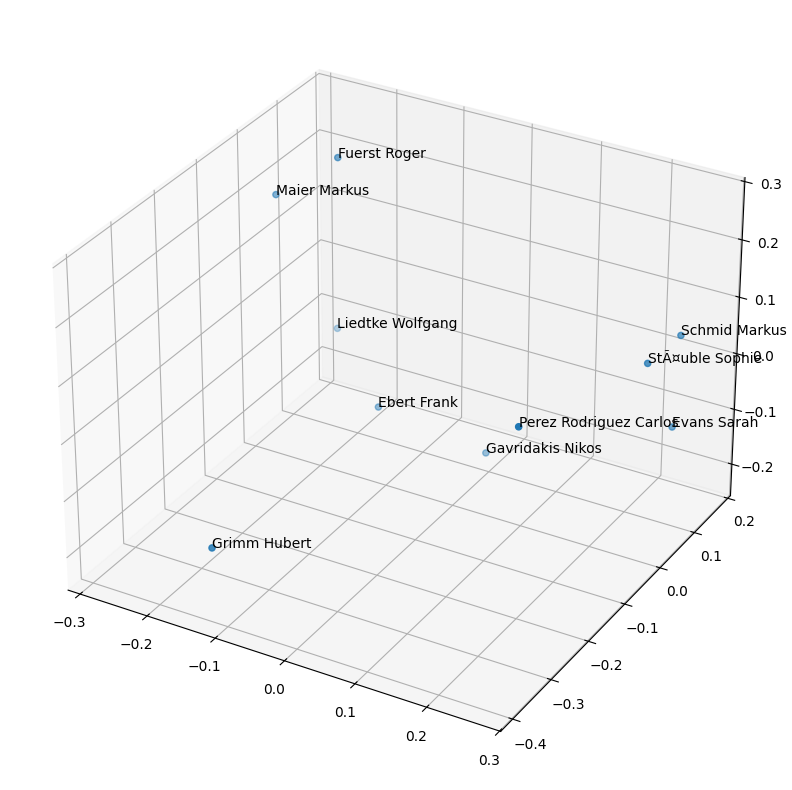

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t[:,0],t[:,1], t[:,2])
for i, txt in enumerate(res['full_name']):
    ax.text(t[i,0], t[i,1], t[i,2], txt)
plt.show()